In [ ]:
!pip install einops
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torchvision.transforms import Compose, Resize, ToTensor

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/project')

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [ ]:
import os
import pandas as pd
from PIL import Image
from sklearn.utils import shuffle

W = 224
H = 224
root_folder = "lung-and-colon-cancer-histopathological-images/lung_colon_image_set"

label_to_class = {'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}

data = {'image_path': [], 'label': []}

for folder in os.listdir(root_folder):
    dataset = os.path.join(root_folder, folder)
    for sub_folder in os.listdir(dataset):
        img_folder = os.path.join(dataset, sub_folder)
        cls = label_to_class.get(sub_folder, -1)
        if cls == -1:
            continue

        for img_name in os.listdir(img_folder):
            img_path = os.path.join(img_folder, img_name)
            data['image_path'].append(img_path)
            data['label'].append(cls)

df = pd.DataFrame(data)
df = shuffle(df, random_state=0)



In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_images = list(zip(train_df['image_path'], train_df['label']))
test_images = list(zip(test_df['image_path'], test_df['label']))


In [ ]:
train_df.shape

(18967, 2)

In [ ]:
test_df.shape

(4742, 2)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}


In [ ]:
from torchvision import datasets, transforms

class CustomImageDataset(datasets.VisionDataset):
    def __init__(self, image_label_pairs, transform=None):
        super().__init__(root="", transform=transform)
        self.image_paths = [img[0] for img in image_label_pairs]
        self.labels = [img[1] for img in image_label_pairs]
        self.transform = transform
        self.classes = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = datasets.folder.default_loader(img_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


In [ ]:
from torch.utils.data import DataLoader


image_datasets = {
    'train': CustomImageDataset(train_images, transform=data_transforms['train']),
    'test': CustomImageDataset(test_images, transform=data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=8, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=8, shuffle=False, num_workers=4)
}
print(f"Training set size: {len(image_datasets['train'])}")
print(f"Test set size: {len(image_datasets['test'])}")


Training set size: 18967
Test set size: 4742


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class_names = image_datasets['train'].classes
class_names

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        ) # this breaks down the image in s1xs2 patches, and then flat them

        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1) #prepending the cls token
        x += self.positions
        return x

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len

        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)

        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)

        return out

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, L: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, L * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(L * emb_size, emb_size),
        )

In [ ]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, drop_p: float = 0., forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 **kwargs):

        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, L=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [ ]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, len(class_names)))

In [ ]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 32,
                emb_size: int = 128,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = len(class_names),
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [ ]:
model = ViT(in_channels = 3,
                patch_size = 16,
                emb_size = 768,
                img_size  = 224,
                depth = 12,
                n_classes = 5).to(device)

In [ ]:
!pip install torchsummary


In [ ]:
from torchsummary import summary
print(summary(ViT(), (3,224,224), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 7, 7]         393,344
         Rearrange-2              [-1, 49, 128]               0
    PatchEmbedding-3              [-1, 50, 128]               0
         LayerNorm-4              [-1, 50, 128]             256
            Linear-5              [-1, 50, 384]          49,536
           Dropout-6            [-1, 8, 50, 50]               0
            Linear-7              [-1, 50, 128]          16,512
MultiHeadAttention-8              [-1, 50, 128]               0
           Dropout-9              [-1, 50, 128]               0
      ResidualAdd-10              [-1, 50, 128]               0
        LayerNorm-11              [-1, 50, 128]             256
           Linear-12              [-1, 50, 512]          66,048
             GELU-13              [-1, 50, 512]               0
          Dropout-14              [-1, 

In [ ]:

epochs = 10
lr = 0.0001
gamma = 0.7
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(dataloaders['train']):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(dataloaders['train'])
        epoch_loss += loss / len(dataloaders['train'])

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in dataloaders['test']:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(dataloaders['test'])
            epoch_val_loss += val_loss / len(dataloaders['test'])

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.4867 - acc: 0.7840 - val_loss : 0.4238 - val_acc: 0.8124



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.3449 - acc: 0.8544 - val_loss : 0.2866 - val_acc: 0.8840



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.3326 - acc: 0.8601 - val_loss : 0.3987 - val_acc: 0.8274



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.3145 - acc: 0.8657 - val_loss : 0.2727 - val_acc: 0.8864



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.3243 - acc: 0.8622 - val_loss : 0.5086 - val_acc: 0.7922



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.2984 - acc: 0.8747 - val_loss : 0.2899 - val_acc: 0.8838



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.3213 - acc: 0.8629 - val_loss : 0.3613 - val_acc: 0.8486



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4346 - acc: 0.8049 - val_loss : 0.4805 - val_acc: 0.7724



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.3877 - acc: 0.8334 - val_loss : 0.4918 - val_acc: 0.7568



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.3666 - acc: 0.8422 - val_loss : 0.3461 - val_acc: 0.8486



In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()

all_test_labels = []
all_test_preds = []

with torch.no_grad():
    for data, label in dataloaders['test']:
        data = data.to(device)
        label = label.to(device)


        output = model(data)
        preds = output.argmax(dim=1)

        all_test_labels.extend(label.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())


test_labels_np = np.array(all_test_labels)
test_preds_np = np.array(all_test_preds)



In [ ]:
unique_values, counts = np.unique(test_preds_np, return_counts=True)

print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1 2 3 4]
Counts: [1309  656  857 1051 1127]


In [ ]:
test_preds_np

array([2, 0, 0, ..., 1, 2, 1])

In [ ]:
class_names=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

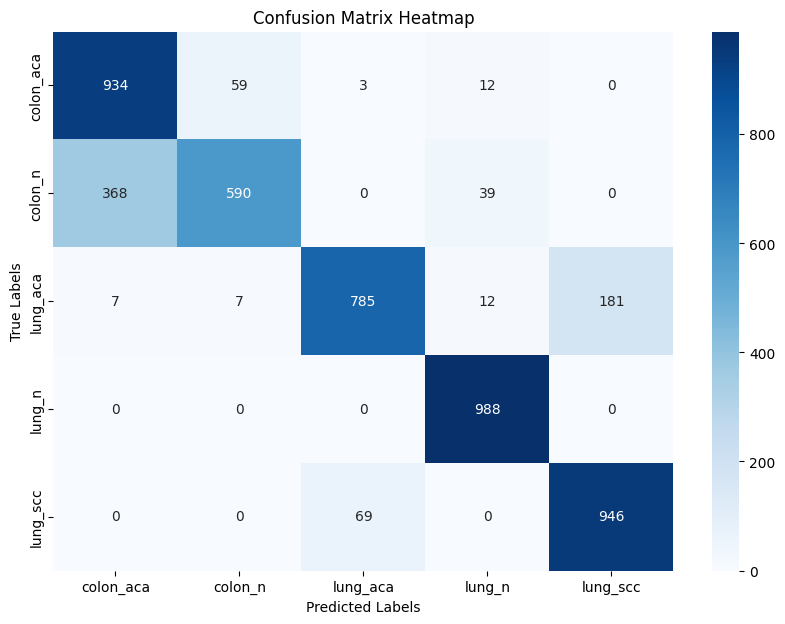

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

label_mapping = {i: name for i, name in enumerate(class_names)}

test_labels_str = np.array([label_mapping[label] for label in test_labels_np])
test_preds_str = np.array([label_mapping[label] for label in test_preds_np])

test_confusion_matrix = confusion_matrix(test_labels_str, test_preds_str, labels=class_names)

plt.figure(figsize=(10, 7))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
class_report = classification_report(test_labels_str, test_preds_str, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.71      0.93      0.81      1008
     colon_n       0.90      0.59      0.71       997
    lung_aca       0.92      0.79      0.85       992
      lung_n       0.94      1.00      0.97       988
    lung_scc       0.84      0.93      0.88      1015

    accuracy                           0.85      5000
   macro avg       0.86      0.85      0.84      5000
weighted avg       0.86      0.85      0.84      5000



In [ ]:
import torch

torch.save(model.state_dict(), 'model_weights.pth')
torch.save(model, 'full_model.pth')